This notebook is to inspect the PSI-MAS datacubes using the psipy package

In [13]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import astropy.units as u
from astropy.time import Time
from sunpy.coordinates import sun
import sunpy.coordinates.ephemeris as eph
from sunpy.coordinates import get_horizons_coord
import matplotlib.pyplot as plt
from psipy.model import MASOutput

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs

# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'

In [11]:
# Define the observation date
mydatetime = '2024-05-14T17:10'
year, month, day = mydatetime.split('T')[0].split('-')
hour, minute     = mydatetime.split('T')[1].split(':')
print(year, month, day, hour, minute) # sanity check

2024 05 14 17 10


In [12]:
# get the Carrington rotation number at the specified datetime 
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))
print(cr)

2284


### Use `psipy` package

In [42]:
# Load MAS model
mas_path = f'{data_dir}/PSI_MAS/{year}{month}{day}_{hour}{minute}/'
model = MASOutput(mas_path)
print(mas_path) # sanity check

/home/mnedal/data/PSI_MAS/20240514_1710/


In [43]:
print(model.variables) # sanity check

['bp', 'br', 'bt', 'cs', 'em', 'ep', 'heat', 'jp', 'jr', 'jt', 'p', 'rho', 't', 'va', 'vp', 'vr', 'vt']


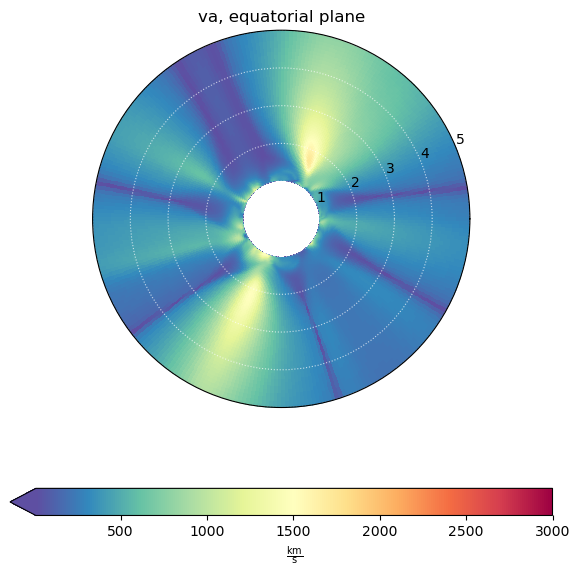

In [102]:
# Plotting equatorial slices
cbar_kwargs = {'orientation': 'horizontal'}

ax = plt.subplot(projection='polar')
model['va'].plot_equatorial_cut(ax=ax, cbar_kwargs=cbar_kwargs, vmin=10, vmax=3000, cmap='Spectral_r')
ax.grid(color='w', linestyle=':', alpha=0.7)
ax.set_ylim(0, 5)  # Limits the radial distance to 5
plt.show()

In [208]:
# Get Earth's coords
time = Time(mydatetime)
earth_coords = get_horizons_coord('399', time)

print(earth_coords) # Sanity check

2025-04-01 18:51:52 - sunpy - INFO: Obtained JPL HORIZONS location for Earth (399)                    


INFO: Obtained JPL HORIZONS location for Earth (399)                     [sunpy.coordinates.ephemeris]
<SkyCoord (HeliographicStonyhurst: obstime=2024-05-14 17:10:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (-8.32068281e-07, -2.67381706, 1.01079589)>


In [209]:
# Get Earth's Carrington longitude
carr_lon = earth_coords.lon.to(u.deg).value
# Convert longitude to radians for polar plot
theta = np.deg2rad(carr_lon)

# Define arrow start and end points
r_start = 2.5
r_end   = 4

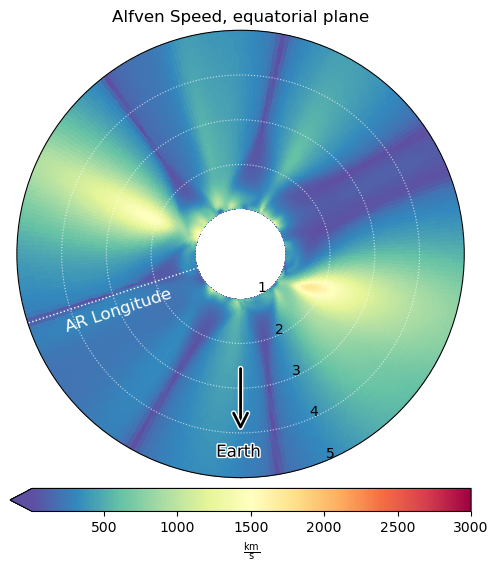

In [225]:
# Plot the MAS equatorial slice
cbar_kwargs = {
    'orientation': 'horizontal',
    'pad': 0.02, 'shrink': 0.85
}

ax = plt.subplot(projection='polar')
model['va'].plot_equatorial_cut(ax=ax, cbar_kwargs=cbar_kwargs, vmin=10, vmax=3000, cmap='Spectral_r')
ax.set_title('Alfven Speed, equatorial plane')

# Plot the arrow
arrow = ax.annotate('', 
            xy=(theta, r_end), xytext=(theta, r_start),
            arrowprops=dict(arrowstyle='->', color='k', lw=2, facecolor='k', edgecolor='w', mutation_scale=25))
import matplotlib.patheffects as path_effects  # For the white outline
arrow.arrow_patch.set_path_effects([
    path_effects.Stroke(linewidth=4, foreground='w'),  # White outline around arrow
    path_effects.Normal()  # Normal arrow on top
])
# Add the text "Earth" next to the arrow
text = ax.text(theta-0.01, r_end+0.6, 'Earth', color='k', fontsize=12, ha='center', va='bottom')
# Apply the white outline to the text
text.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='w'),  # White outline around text
    path_effects.Normal()  # Normal text on top
])

# Define the angle in degrees and convert to radians
angle_deg = -72
angle_rad = np.radians(angle_deg)
# Define the radius range
rLine_start = 1
rLine_end = 5
# Plot the dotted line from the Active Region, where the CME was launhed
rLine     = np.array([rLine_start, rLine_end]) # Define the radius range
thetaLine = np.array([angle_rad, angle_rad])   # Constant angle for the line
ax.plot(thetaLine, rLine, linestyle=':', color='w', lw=1)
# Add the text next to the line
text_radius = (rLine_start + rLine_end) / 2    # Midpoint of the radius range
ax.text(angle_rad+np.radians(7), text_radius, 'AR Longitude', color='w', fontsize=12, va='center', ha='center', rotation=angle_deg+90)

ax.grid(color='w', linestyle=':', alpha=0.7)
ax.set_ylim(0, 5) # Set the radial limit
ax.set_theta_offset(-np.pi/2) # Rotate the polar plot by 90 degrees (pi/2 radians)
# plt.savefig(f'{data_dir}/valfven_equatorial_cut.pdf', format='pdf', bbox_inches='tight')
plt.show()